
Data Dictionary and Overview (from Kaggle https://www.kaggle.com/datasets/udaymalviya/bank-loan-data?resource=download)

This dataset contains 45,000 records of loan applicants, with various attributes related to personal demographics, financial status, and loan details.

Personal Information

person_age: Age of the applicant (in years).

person_gender: Gender of the applicant (male, female).

person_education: Educational background (High School, Bachelor, Master, etc.).

person_income: Annual income of the applicant (in USD).

person_emp_exp: Years of employment experience.

person_home_ownership: Type of home ownership (RENT, OWN, MORTGAGE).


Loan Details

loan_amnt: Loan amount requested (in USD).

loan_intent: Purpose of the loan (PERSONAL, EDUCATION, MEDICAL, etc.).

loan_int_rate: Interest rate on the loan (percentage).

loan_percent_income: Ratio of loan amount to income.


Credit & Loan History

cb_person_cred_hist_length: Length of the applicant"s credit history (in years).

credit_score: Credit score of the applicant.

previous_loan_defaults_on_file: Whether the applicant has previous loan defaults (Yes or No).



Target Variable

loan_status: 1 if the loan was repaid successfully, 0 if the applicant defaulted.


In [2]:
import pandas as pd
# Step 1 Clean the data
df = pd.read_csv("loan_data.csv")

# See if there are rows with nulls that need to be removed
rows_with_nulls = df.isna().any(axis=1).sum()
print(f"Number of rows with null values: {rows_with_nulls}")

# No nulls so we are fine

Number of rows with null values: 0


In [ ]:
# Step 2 Some basic EDA
print(df.describe(include="all"))

          person_age person_gender person_education  person_income  \
count   45000.000000         45000            45000   4.500000e+04   
unique           NaN             2                5            NaN   
top              NaN          male         Bachelor            NaN   
freq             NaN         24841            13399            NaN   
mean       27.764178           NaN              NaN   8.031905e+04   
std         6.045108           NaN              NaN   8.042250e+04   
min        20.000000           NaN              NaN   8.000000e+03   
25%        24.000000           NaN              NaN   4.720400e+04   
50%        26.000000           NaN              NaN   6.704800e+04   
75%        30.000000           NaN              NaN   9.578925e+04   
max       144.000000           NaN              NaN   7.200766e+06   

        person_emp_exp person_home_ownership     loan_amnt loan_intent  \
count     45000.000000                 45000  45000.000000       45000   
unique     

In [ ]:
# View df
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [3]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Step 3 Preprocess

# Convert yes no column to boolean
loans_bool = (np.where(df["previous_loan_defaults_on_file"] == "Yes", True, False)).reshape(-1, 1)

# Seperate out dependent variable
y = df["loan_status"]


# Numerical Variables
numerical = df[["person_age", "person_income", "person_emp_exp", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "credit_score"]]

# Min Max scale numerical data
scaler = preprocessing.MinMaxScaler()
numerical_scaled = scaler.fit_transform(numerical)


# Categorical Variables
categorical = df[["person_gender", "person_education", "person_home_ownership", "loan_intent"]]
categorical_dummies = pd.get_dummies(categorical, drop_first=True)
categorical_dummies_array = np.array(categorical_dummies)

# Column names / order
columns = list(numerical.columns) + list(categorical_dummies.columns) + ["previous_loan_defaults_on_file"]

# Create Phi with numerical, categorical, and boolean variables
Phi = np.hstack((numerical_scaled, categorical_dummies_array, loans_bool))

print(f"Number of columns after preprocessing: {Phi.shape[1]}")

X_train, X_test, y_train, y_test = train_test_split(Phi, y, test_size=0.2, random_state=23)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

Number of columns after preprocessing: 22


In [ ]:
# KNN
import numpy as np
import matplotlib.pyplot as plt

def run_knn(X_train, y_train, X_test, y_test, k):
    predictions = []

    for test_point in X_test:
        # L2 distances
        distances = np.sqrt(np.sum((X_train - test_point) ** 2, axis=1))

        # K nearest neighbors
        knn_indices = np.argsort(distances)[:k]
        knn_labels = y_train[knn_indices]

        # Calculate mode
        unique_values, counts = np.unique(knn_labels, return_counts=True)
        mode_index = np.argmax(counts)
        predicted_class = unique_values[mode_index]

        predictions.append(predicted_class)

    # Prediction accuracy
    y_pred = np.array(predictions)
    accuracy = np.mean(y_pred == y_test)
    return accuracy, y_pred

K = 5, Accuracy: 0.8881
K = 10, Accuracy: 0.8914
K = 25, Accuracy: 0.8950
K = 50, Accuracy: 0.8909
K = 75, Accuracy: 0.8854
K = 100, Accuracy: 0.8742
K = 125, Accuracy: 0.8697
K = 150, Accuracy: 0.8629
K = 175, Accuracy: 0.8650
K = 190, Accuracy: 0.8632
K = 200, Accuracy: 0.8626
K = 225, Accuracy: 0.8639
K = 250, Accuracy: 0.8657


<function matplotlib.pyplot.show(close=None, block=None)>

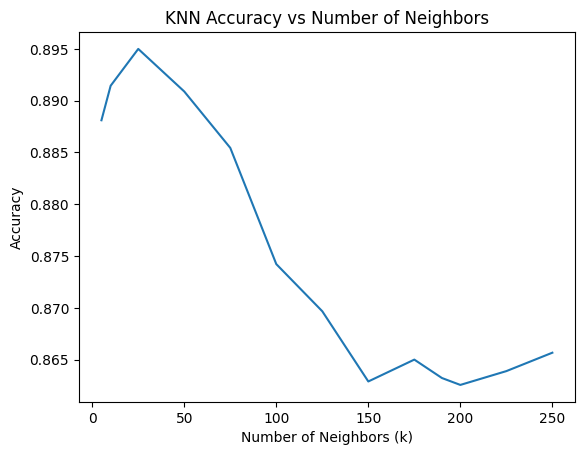

In [ ]:
# Params
n = X_train.shape[0]
sqrt_n = int(np.sqrt(n).round())  # 190

k_values = [5, 10, 25, 50, 75, 100, 125, 150, 175, sqrt_n, 200, 225, 250]   # Some test ks


# Run KNN for different k values in a for loop
accuracies = []
for k in k_values:
    accuracy, y_pred = run_knn(X_train, y_train, X_test, y_test, k)
    accuracies.append(accuracy)
    print(f"K = {k}, Accuracy: {accuracy:.4f}")

# Plot k vs accuracy
plt.plot(k_values, accuracies)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs Number of Neighbors")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Best k was 25
k = 25
accuracy, predictions = run_knn(X_train, y_train, X_test, y_test, k)
y_pred = np.array(predictions)
print(f"K = {k}, Accuracy: {accuracy:.4f}")

# Precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


K = 25, Accuracy: 0.8950
Precision: 0.8333
Recall: 0.6608
F1 Score: 0.7371

Confusion Matrix:
[[6730  265]
 [ 680 1325]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      6995
           1       0.83      0.66      0.74      2005

    accuracy                           0.90      9000
   macro avg       0.87      0.81      0.84      9000
weighted avg       0.89      0.90      0.89      9000



The best k was clearly 25 (though this is also very dependent on the random state), and the results were decently strong with an accuracy of 90% correct predictions. There is clearly a strong class imbalance with more 0s than 1s, and the model is not handling that very well with significantly lower prediction accuracies for predicting a 1 than a 0. This could potentially be improved by imputing some dummy data points.

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# We can use the same train test as scaling should not matter for random forest

rf = RandomForestClassifier(max_depth=None, random_state=23, criterion="entropy")

# Train the model
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Model performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# Feature importance
feature_importance = rf.feature_importances_
feature_names = [f"Feature {i}" for i in range(Phi.shape[1])]

# Make feature importance and display top 10
importance_df = pd.DataFrame({"Feature": columns, "Importance": feature_importance})
importance_df = importance_df.sort_values("Importance", ascending=False)
print("\nFeature Importance:")
print(importance_df.head(10))



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      6995
           1       0.90      0.75      0.82      2005

    accuracy                           0.93      9000
   macro avg       0.91      0.86      0.89      9000
weighted avg       0.92      0.93      0.92      9000


Confusion Matrix:
[[6818  177]
 [ 493 1512]]

Feature Importance:
                           Feature  Importance
21  previous_loan_defaults_on_file    0.284019
4                    loan_int_rate    0.140659
5              loan_percent_income    0.139325
1                    person_income    0.113094
3                        loan_amnt    0.059230
7                     credit_score    0.053026
15      person_home_ownership_RENT    0.047536
0                       person_age    0.031821
2                   person_emp_exp    0.028236
6       cb_person_cred_hist_length    0.026445


The model does better at predicting 0s (defaulting the loan) than 1s (completing the payment). This is likely due to a strong class imbalance with more 0s than 1s in the dataset. Despite the strong imbalance, the model results were relatively good with an accuracy of 93% correct predictions. The model is clearly better than the knn, and significantly outperforms it for predicting 1s.

The most important features that provided the best splits were the persons yearly income, the loan percent of the income, the loan interest rate, and by far if the person had previous loan defaults on file. These all make a lot of sense as they seem incredibly relevant to the prediction. All of these statistics are very strongly correlated, so I wonder if they are not all necessary in a simplified model.

In [4]:
# Logistic Regression
def sigmoid(x, w):
    return 1/(1 + np.exp(-x.T.dot(w)))

def logistic_grad(X, y, w):
    L = 0
    for i, j in enumerate(X):
        x = j.reshape(X.shape[1], 1)
        L += (sigmoid(x, w) - y[i])*x

    dL_dw = L/len(X)
    return dL_dw

def gradient_descent(X, y, w, eta, epochs):
    for i in range(epochs):
        w = w - eta*logistic_grad(X, y, w)
    return w

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
# Params
w0 = np.ones(X_train.shape[1]).reshape(-1, 1)
eta = 0.1
epochs = 2000

# Run Gradient Descent to (hopefully) improve predictions
w_gd = gradient_descent(X_train, y_train, w0, eta, epochs)

In [10]:
# Evaluate logistic regression model
preds = []
for i in range(X_test.shape[0]):
    preds.append(int(sigmoid(X_test[i,:], w_gd)[0] > .5))

# Confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=preds)
true_positive = conf_mat[1,1]
false_positive = conf_mat[0,1]
true_negative = conf_mat[0,0]
false_negative = conf_mat[1,0]

# Calculate and print model results
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
F1_score = (2*true_positive) / (2*true_positive + false_positive + false_negative)

print(f"Accuracy of the algorithm: {accuracy}")
print(f"Precision of the algorithm: {precision}")
print(f"Recall of the algorithm: {recall}")
print(f"F1 Score of the algorithm: {F1_score}")



# Create and sort importance dataframe
importance_df = pd.DataFrame({"Feature": columns, "Weight": w_gd.reshape(-1), "Abs Weight": np.abs(w_gd.reshape(-1))})
importance_df = importance_df.sort_values("Abs Weight", ascending=False)
print(importance_df)
# print(w_gd)

Accuracy of the algorithm: 0.8803333333333333
Precision of the algorithm: 0.7473347547974414
Recall of the algorithm: 0.6992518703241896
F1 Score of the algorithm: 0.7224942025251224
                           Feature    Weight  Abs Weight
21  previous_loan_defaults_on_file -4.355207    4.355207
7                     credit_score -2.559459    2.559459
5              loan_percent_income  1.902508    1.902508
4                    loan_int_rate  1.586531    1.586531
13     person_home_ownership_OTHER  0.962303    0.962303
15      person_home_ownership_RENT  0.947924    0.947924
1                    person_income  0.865446    0.865446
20             loan_intent_VENTURE -0.717456    0.717456
16           loan_intent_EDUCATION -0.574137    0.574137
2                   person_emp_exp  0.554522    0.554522
10      person_education_Doctorate  0.533120    0.533120
0                       person_age  0.435048    0.435048
19            loan_intent_PERSONAL -0.415268    0.415268
6       cb_person_c

In [ ]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# 2d space
lda = LinearDiscriminantAnalysis(n_components=2)

# Train model
lda.fit(X_train, y_train)

# Predict on the Test Set
y_pred = lda.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

X_transformed = lda.transform(Phi)

# Plot 2d data
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap='viridis')
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.title("Iris Dataset - LDA")
plt.colorbar(label="Species")
plt.show()
